<a href="https://colab.research.google.com/github/SamuelEyrolle/DGCCA-PyTorch-Implementation/blob/main/DGCCA_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DGCCA Implementation

This Google Colab notebook implements Deep Generalised Canonical Correlation Analysis (DGCCA). Unlike standard CCA which is limited to two linear views, DGCCA uses multiple deep neural networks (one per view) to project $n$-view data into a common, low-dimensional latent space. The goal is to maximise the correlation between these nonlinear mappings, effectively extracting the shared signal from noise-heavy, multi-modal data.

### Environment Setup & Reproducibility

This section handles the initial configuration of the workspace. We import essential libraries for deep learning, data manipulation, and visualisation. Additionally, a manual seed is implemented to ensure that stochastic processes, like weight initialisation and data shuffling, produce reproducible results across different runs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensuring reproducibility for synthetic data and weight initialisation
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Multi-View Data Generation & Synthetic Distortion

To test the DGCCA model's ability to recover shared information, this cell creates a synthetic "ground truth."
1. **Shared Signal**: We define three distinct clusters in a 3D latent space.
2. **Projection & Warping**: This signal is projected into a higher 10D space and subjected to view-specific non-linearities (Exponential, Sine, and Power Warping).
3. **Noise Injection**: High-dimensional Gaussian noise is added to further obscure the clusters.
The resulting dataset simulates a real-world scenario where multiple sensors (views) observe the same phenomenon but through different noisy lenses.

In [2]:
# Create synthetic views to run DGCCA
def generate_dgcca_cluster_data(n_samples=900, n_views=3, noise_level=0.2):
    """
    Generates 3 distinct clusters in a shared 3D space, then hides them
    in high-dimensional noise for each view.
    """
    n_clusters = 3
    samples_per_cluster = n_samples // n_clusters

    # 1. Create the 'Ground Truth' Shared Signal
    # We create 3 distinct centers in 3D space
    centers = np.array([[2, 0, 2], [-2, -2, 2], [0, 0, -2]])
    shared_signal = []
    labels = []

    for i in range(n_clusters):
        cluster_data = centers[i] + np.random.randn(samples_per_cluster, 3) * 0.6
        shared_signal.append(cluster_data)
        labels.append(np.full(samples_per_cluster, i))

    shared_signal = np.concatenate(shared_signal, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Determine the actual number of samples generated after division and concatenation
    n_samples_actual = shared_signal.shape[0]

    # Shuffle to ensure batches are mixed
    # Use the actual number of samples for permutation
    idx = np.random.permutation(n_samples_actual)
    shared_signal, labels = shared_signal[idx], labels[idx]

    views = []
    for v in range(n_views):
        # Project 3D truth into 10D
        proj = np.random.randn(3, 10)
        view_data = np.dot(shared_signal, proj)

        # Add a "View-Specific" distortion to make the clusters hard to find
        if v == 0:
            view_data = np.exp(view_data / 10.0) # Exponential warping
        elif v == 1:
            view_data = np.sin(view_data * 2)    # Periodic warping
        else:
            view_data = np.abs(view_data)**1.5   # Power warping

        # Add high noise
        # Use n_samples_actual here as well to match the actual data size
        view_data += np.random.randn(n_samples_actual, 10) * noise_level
        views.append(torch.tensor(view_data, dtype=torch.float32))

    return views, labels

# Generate 3 views, each with 10 features
views, color_labels = generate_dgcca_cluster_data(n_samples=900, n_views=3)

# Combine into a single Dataset for the PyTorch DataLoader
dataset = TensorDataset(*views)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Generated {len(views)} views with shapes: {[v.shape for v in views]}")

Generated 3 views with shapes: [torch.Size([900, 10]), torch.Size([900, 10]), torch.Size([900, 10])]


### GCCA Loss Function & Latent Estimation

This section implements the core mathematical objective for multi-view fusion. The *generalised_gcca_loss* function calculates how well the views align in a shared latent space. It follows a three-step process:
1. **Centering**: Removing the mean from each view to focus on variance.
2. **SVD Decomposition**: Extracting the principal components of each view and scaling them for numerical stability.
3. **Canonical Correlation**: Using QR Decomposition and a second SVD to find the shared matrix $G$, which represents the common signal across all inputs.
The loss returned is the negative sum of correlations, allowing the optimiser to maximise the alignment between views.

In [3]:
def generalised_gcca_loss(views, top_k=50, eps=1e-8):
    """
    Computes the Generalised Canonical Correlation Analysis loss for N views.

    Args:
        views (list of torch.Tensor): List of tensors [H1, H2, ... Hn],
                                      each of shape (n_samples, feature_dim).
        top_k (int): Number of latent components to retain.
        eps (float): Numerical stability constant.

    Returns:
        loss (torch.Tensor): Negative sum of correlations (to be minimised).
        G (torch.Tensor): The shared representation matrix.
    """
    # 1. Validation and Setup
    n_views = len(views)
    n_samples = views[0].size(0)
    feature_dim = views[0].size(1)
    device = views[0].device

    # Ensure all views have no NaNs and are on the same device
    for i, h in enumerate(views):
        if torch.isnan(h).any():
            raise ValueError(f"NaN detected in view {i}")

    # 2. Centering the Data
    # H_bar = H - mean(H)
    centered_views = []
    for h in views:
        h_bar = h - torch.mean(h, dim=0)
        centered_views.append(h_bar)

    # 3. SVD for each view to compute scaled singular vectors (AT)
    AT_list = []
    for h_bar in centered_views:
        # SVD: H = U S V^T
        U, S, V = torch.svd(h_bar, some=True)

        # Keep top_k components
        U_k = U[:, :top_k]
        S_k = S[:top_k]

        # Calculate scaling factor T: sqrt(S^2 / (S^2 + eps))
        # This normalises the variance explained by each component
        S2 = torch.mul(S_k, S_k)
        T_diag = torch.sqrt(S2 / (S2 + eps))
        T = torch.diag(T_diag)

        # Scaled left singular vectors
        AT = torch.mm(U_k, T)
        AT_list.append(AT)

    # 4. Construct M_tilde and solve for shared G
    # M_tilde is the horizontal concatenation of all scaled view representations
    M_tilde = torch.cat(AT_list, dim=1)

    # QR Decomposition for numerical efficiency
    Q, R = torch.linalg.qr(M_tilde)

    # SVD of R to find the shared latent space G
    # Using torch.linalg.svd for modern PyTorch compatibility
    U_r, S_r, V_r = torch.linalg.svd(R, full_matrices=False)

    # G is the projection of Q onto the top singular vectors of R
    G = torch.mm(Q, U_r[:, :top_k])

    # 5. Calculate Correlation (The objective to maximise)
    # We take the top_k singular values of M_tilde
    # Note: S_r contains the singular values of M_tilde due to QR properties
    corr = torch.sum(S_r[:top_k])

    # Loss is negative correlation (since we use gradient descent to minimise)
    loss = -corr

    return loss, G

### Model Architecture: Multi-View Deep Encoders

This section defines the neural network components for the DGCCA framework.
- *MlpNet* (Encoder): A flexible Multi-Layer Perceptron (MLP) responsible for learning the non-linear mappings of a single view. It uses ReLU activations for hidden layers to capture complex patterns and a Sigmoid activation in the final layer to constrain the output to a unit interval. Batch Normalisation is applied at the output to ensure stable feature distributions.
- *DeepGCCA* (Wrapper): A container that manages multiple independent encoders.

In [4]:
class MlpNet(nn.Module):
    """
    Encoder network for a single view.
    Transforms raw input features into a shared latent space.
    """
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        # Chain the input size with the hidden layers
        all_sizes = [input_size] + layer_sizes

        for i in range(len(all_sizes) - 1):
            is_last = (i == len(all_sizes) - 2)

            layers.append(nn.Linear(all_sizes[i], all_sizes[i + 1]))

            if is_last:
                # The final layer uses Sigmoid and BatchNorm as per original implementation
                layers.append(nn.Sigmoid())
                layers.append(nn.BatchNorm1d(num_features=all_sizes[i + 1], affine=False))
            else:
                # Hidden layers use ReLU
                layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class DeepGCCA(nn.Module):
    """
    Generalised Deep GCCA wrapper that manages N independent encoders.
    """
    def __init__(self, view_configs, device=torch.device('cpu')):
        """
        Args:
            view_configs (list of dict): Each dict contains 'input_size' and 'layer_sizes'.
            device: torch device.
        """
        super(DeepGCCA, self).__init__()

        # We use ModuleList so PyTorch tracks all encoders for backpropagation
        self.encoders = nn.ModuleList([
            MlpNet(cfg['layer_sizes'], cfg['input_size']) for cfg in view_configs
        ])

        self.to(device)

    def forward(self, views):
        """
        Args:
            views (list of torch.Tensor): Each tensor corresponds to one view.
        Returns:
            list of torch.Tensor: Encoded representations (H1, H2, ... Hn)
        """
        # Pass each view through its corresponding encoder
        return [encoder(v) for encoder, v in zip(self.encoders, views)]

### Hyperparameter Tuning & Model Initialisation

This section defines the optimisation strategy and dynamically configures the neural network architecture based on the input data.
- **Hyperparameters**: We set the learning rate, epoch count, and batch size to control the training dynamics.
- **Bottleneck Logic**: The code automatically validates the ouput target dimension against the smallest input view to ensure numerical stability during the SVD computation.
- **Dynamic Mapping**: Each view receives a tailored configuration, mapping its specific feature count through the hidden structure and into the shared latent space.
- **Initialisation**: The *DeepGCCA* model is initialised and transferred to the active compute device (CPU/GPU).

In [5]:
# --- USER-DEFINED HYPERPARAMETERS ---
# These are the primary knobs you can turn to adjust the model's capacity.
learning_rate = 1e-3     # Step size for the weight updates
epochs = 150             # Total passes through the synthetic dataset
batch_size = 64          # Number of samples processed before updating weights

# The desired number of canonical components (latent dimensions).
# NOTE: This should generally be <= the number of features in your smallest view.
target_outdim = 8

# The structure of the hidden layers between the input and the final embedding.
# For small synthetic views (10-20 features), a smaller network is more stable.
hidden_structure = [32, 64]
# ------------------------------------

# 1. Determine the bottleneck dimension
# We check the synthetic views to ensure target_outdim is valid.
min_features = min([v.shape[1] for v in views])

if target_outdim > min_features:
    print(f"⚠️ Warning: target_outdim ({target_outdim}) is greater than the smallest view ({min_features}).")
    print(f"Adjusting outdim_size to {min_features} for numerical stability.")
    outdim_size = min_features
else:
    outdim_size = target_outdim

# 2. Dynamic Configuration Building
view_configs = []
for i, view_tensor in enumerate(views):
    # The config maps the raw input features -> hidden layers -> shared outdim
    config = {
        'input_size': view_tensor.shape[1],
        'layer_sizes': hidden_structure + [outdim_size]
    }
    view_configs.append(config)

    # Ensure tensors are on the correct device (CPU/CUDA)
    views[i] = view_tensor.to(device)

# 3. Initialise the Generalised DeepGCCA model
model = DeepGCCA(view_configs, device=device)

# 4. Summary for GitHub Documentation
print("-" * 30)
print(f"✅ Model Initialised on {device}")
print(f"Number of Views: {len(view_configs)}")
print(f"Shared Latent Space (G): {outdim_size} dimensions")
print("-" * 30)
for i, cfg in enumerate(view_configs):
    print(f"View {i+1} Encoder: {cfg['input_size']} (In) -> {hidden_structure} (Hidden) -> {outdim_size} (Out)")

------------------------------
✅ Model Initialised on cuda
Number of Views: 3
Shared Latent Space (G): 8 dimensions
------------------------------
View 1 Encoder: 10 (In) -> [32, 64] (Hidden) -> 8 (Out)
View 2 Encoder: 10 (In) -> [32, 64] (Hidden) -> 8 (Out)
View 3 Encoder: 10 (In) -> [32, 64] (Hidden) -> 8 (Out)


### Training Execution: Optimisation and Weight Calibration

This section manages the iterative learning process of the DGCCA model.
- **Weight Initialisation**: We apply Xavier initialisation to all linear layers. This ensures that signal variance remains stable across the deep network.
- **Adaptive Optimisation**: An Adam optimiser is configured with specific momentum (betas) and weight decay to penalise overly complex models and improve generalisation.
- **Learning Rate Scheduling**: A StepLR scheduler is implemented to gradually reduce the step size, allowing the model to "settle" into a global minimum as training progresses.
- **Training Loop**: The loop executes the forward pass, validates numerical stability (NaN checks), computes the GCCA loss, and updates the weights via backpropagation.

In [6]:
import torch.nn.init as init
from copy import deepcopy as copy

# 1. Weight Initialisation
def init_weights(m):
    """
    Applies Xavier Normal initialisation to linear layers.
    This helps maintain stable variance of activations through the network.
    """
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

model.apply(init_weights)

# 2. Optimiser & Scheduler Setup
# Using your specific beta values and weight decay for regularisation
optimiser = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-4
)

# Gradually reduces learning rate to help the model converge in later epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=100, gamma=0.1)

# 3. Training Execution
train_loss = []
model.train()

print(f"Starting training for {epochs} epochs...")

for epoch in range(epochs):
    optimiser.zero_grad()

    # Forward pass: model(views) returns a list of outputs [H1, H2, ... Hn]
    outputs = model(views)

    # Safety Check: Ensure no NaNs were generated during the forward pass
    for i, out in enumerate(outputs):
        if torch.isnan(out).any():
            raise ValueError(f"NaN detected in output of View {i+1} at epoch {epoch}")

    # Calculate Loss using our generalised function
    # outdim_size was defined in the previous step
    loss, G = generalised_gcca_loss(outputs, top_k=outdim_size)

    if loss is None:
        print(f"Loss calculation failed at epoch {epoch}")
        break

    # Backpropagation
    loss.backward()
    optimiser.step()
    scheduler.step()

    # Store loss for plotting (using .item() is more memory-efficient than deepcopy)
    train_loss.append(loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

print("Training complete.")

Starting training for 150 epochs...
Epoch [50/150] - Loss: -11.7182
Epoch [100/150] - Loss: -12.3865
Epoch [150/150] - Loss: -12.4387
Training complete.


### Visualising Convergence: Training Loss Analysis

This section generates a diagnostic plot of the training history. By plotting the Negative Correlation Loss against the number of epochs, we can verify the model's stability and convergence. A steady decline indicates that the encoders are successfully learning to project disparate views into a unified, highly correlated latent space. The grid-stabilised plot provides a clear view of where the model began to plateau, helping us determine if the epoch count was sufficient for the given complexity.

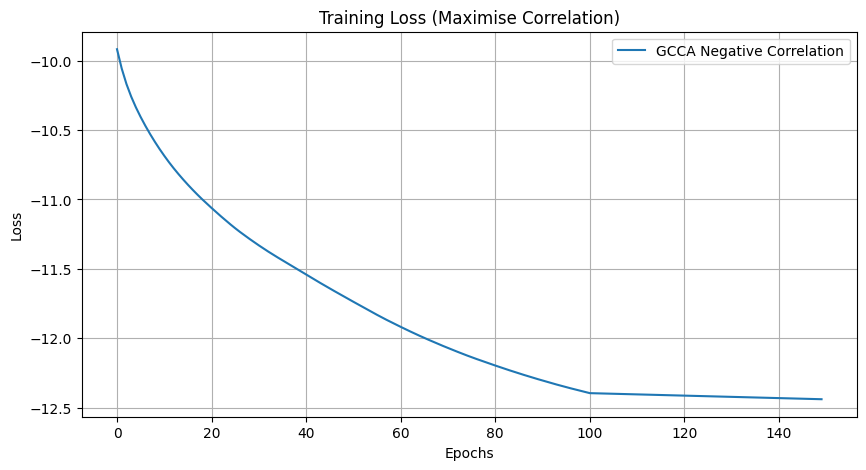

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='GCCA Negative Correlation')
plt.title('Training Loss (Maximise Correlation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Dimensionality Audit

This section verifies the architectural transformations of the pipeline.

In [8]:
print(f"{'Data Stage'}        | {'Shape'}")
print("-" * 35)
# Check original views
for i, v in enumerate(views):
    print(f"Original View {i+1}   | {list(v.shape)}")

# Check encoded views (after forward pass)
with torch.no_grad():
    encoded = model(views)
    for i, h in enumerate(encoded):
        print(f"Encoded View {i+1}    | {list(h.shape)}")

# Check final G
print(f"Final G Space     | {list(G.shape)}")

Data Stage        | Shape
-----------------------------------
Original View 1   | [900, 10]
Original View 2   | [900, 10]
Original View 3   | [900, 10]
Encoded View 1    | [900, 8]
Encoded View 2    | [900, 8]
Encoded View 3    | [900, 8]
Final G Space     | [900, 8]


### Latent Space Visualisation: Comparing Input vs. Shared Representation

This section employs t-SNE (t-distributed Stochastic Neighbour Embedding) to project our high-dimensional data into a 2D plane for qualitative analysis.
- Panel row 1 (Raw Input): Visualises the views as the model sees them—distorted by non-linear functions and submerged in noise.
- Panel row 2 (Encoded Views): Shows the intermediate progress of the individual encoders as they begin to restructure the data.
- Panel row 3 (Shared G): Displays the final "consensus" representation.

A successful DGCCA implementation will show the three original clusters becoming increasingly separated and distinct in the Shared G plot compared to the chaotic distribution of the raw views.

Computing t-SNE for Original View 1...
Computing t-SNE for Original View 2...
Computing t-SNE for Original View 3...
Computing t-SNE for Encoded View 1...
Computing t-SNE for Encoded View 2...
Computing t-SNE for Encoded View 3...
Computing t-SNE for Shared G...


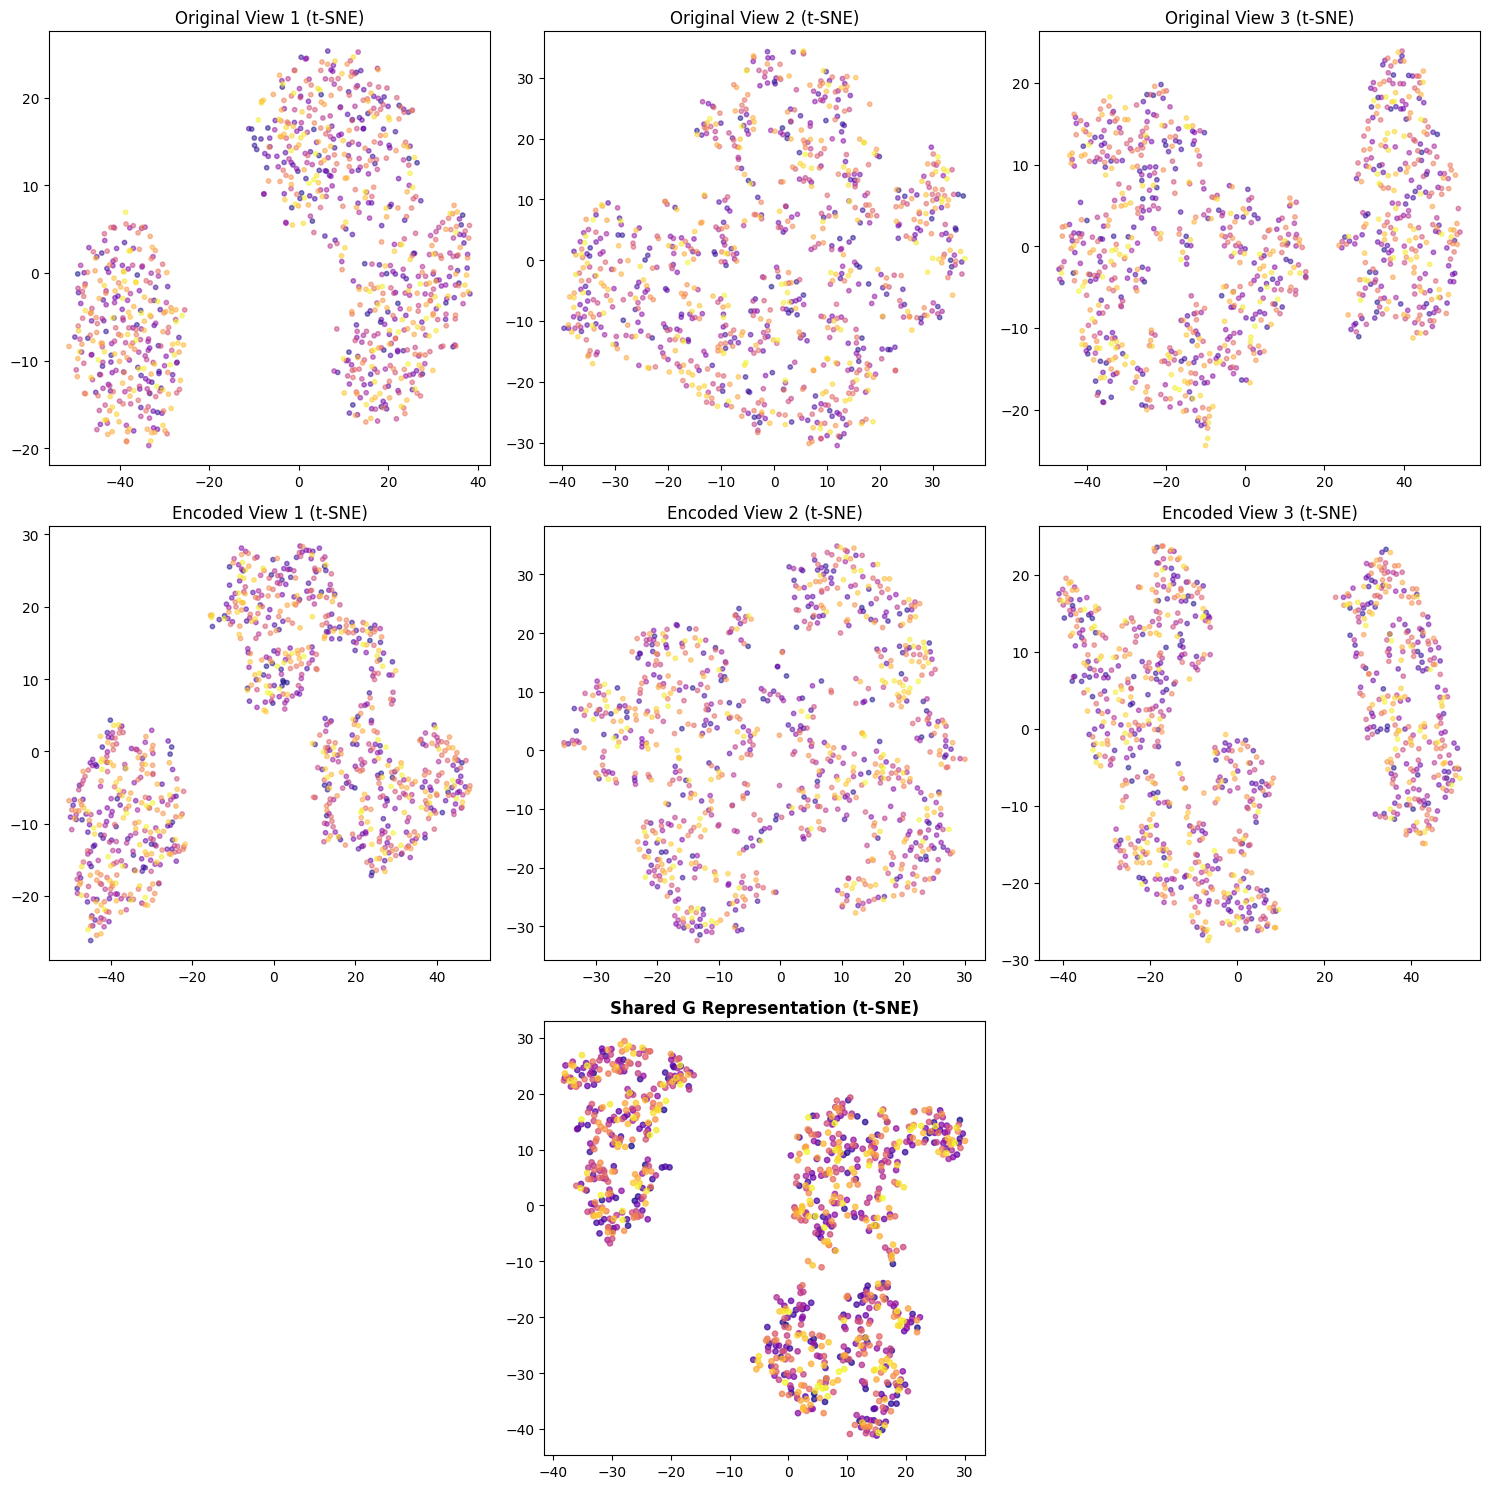

In [9]:
from sklearn.manifold import TSNE

def visualise_dgcca_tsne_grid(model, loader, device, target_outdim):
    model.eval()
    raw_views, encoded_reps = [[] for _ in range(3)], [[] for _ in range(3)]

    # 1. Collect all data from the loader
    with torch.no_grad():
        for batch_views in loader:
            for i in range(3):
                raw_views[i].append(batch_views[i].numpy())

            batch_views_dev = [v.to(device) for v in batch_views]
            outputs = model(batch_views_dev)
            for i, out in enumerate(outputs):
                encoded_reps[i].append(out.cpu().numpy())

    raw_views = [np.concatenate(v, axis=0) for v in raw_views]
    encoded_reps = [np.concatenate(v, axis=0) for v in encoded_reps]

    # 2. Compute G from the full encoded set
    combined_tensor = [torch.tensor(r).to(device) for r in encoded_reps]
    _, G_tensor = generalised_gcca_loss(combined_tensor, top_k=target_outdim)
    shared_G = G_tensor.cpu().numpy()

    # 3. Visualization Setup
    # Use a perplexity related to your sample size (usually 30-50)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    sample_colors = np.linspace(0, 1, len(shared_G))
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # Row 1: Original Views
    for i in range(3):
        print(f"Computing t-SNE for Original View {i+1}...")
        coords = tsne.fit_transform(raw_views[i])
        axes[0, i].scatter(coords[:, 0], coords[:, 1], c=sample_colors, cmap='plasma', s=10, alpha=0.5)
        axes[0, i].set_title(f"Original View {i+1} (t-SNE)")

    # Row 2: Encoded Views
    for i in range(3):
        print(f"Computing t-SNE for Encoded View {i+1}...")
        coords = tsne.fit_transform(encoded_reps[i])
        axes[1, i].scatter(coords[:, 0], coords[:, 1], c=sample_colors, cmap='plasma', s=10, alpha=0.5)
        axes[1, i].set_title(f"Encoded View {i+1} (t-SNE)")

    # Row 3: G Representation
    axes[2, 0].axis('off')
    print("Computing t-SNE for Shared G...")
    coords_g = tsne.fit_transform(shared_G)
    axes[2, 1].scatter(coords_g[:, 0], coords_g[:, 1], c=sample_colors, cmap='plasma', s=15, alpha=0.7)
    axes[2, 1].set_title("Shared G Representation (t-SNE)", fontweight='bold')
    axes[2, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Execute the visualisation
visualise_dgcca_tsne_grid(model, train_loader, device, outdim_size)